In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
from torch.autograd import Variable
import torch.nn.functional as functional_model

# Suppress an irritating warning with pandas
import warnings
warnings.filterwarnings("ignore")

### Data, Model, and Evaluation ###

The data used was the "breast-cancer-wisconsin.data" from the UCI url provided.
This set included 11 columns, including ID number and diagnosis.

The model is a simple linear binary classifier, using less than 300 epochs and a learning rate of 0.01.
I noticed slghtly worse predictions using "mean" for the loss function rather than "sum"
I still got over 98% with mean, but sum would often hit 100%
The model was run using a CUDA capable Nvidia card.

For evaluation, I used sklearn's train_test_split to get test and train sets
As the model uses a sigmoid, the test set is tested for greather than 0.5, returning an np array of boolean values
The model, with the current hyperparameters, was getting a 98% to 100% accuracy with a train-test of 10% with random state 42

In [2]:
# Headers names taken directly from the "breast_cancer_wisconsin.names" file

data = pd.read_csv("bcw.data", names=["id_number",
                                     "Clump_Thickness",
                                     "Uniformity_of_Cell Size",
                                     "Uniformity_of_Cell Shape",
                                     "Marginal_Adhesion",
                                     "Single_Epithelial_Cell_Size",
                                     "Bare_Nuclei",
                                     "Bland_Chromatin",
                                     "Normal_Nucleoli",
                                     "Mitoses",
                                     "Class"])

In [3]:
data

,id_number,Clump_Thickness,Uniformity_of_Cell Size,Uniformity_of_Cell Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


[[<AxesSubplot:title={'center':'id_number'}>
  <AxesSubplot:title={'center':'Clump_Thickness'}>
  <AxesSubplot:title={'center':'Uniformity_of_Cell Size'}>]
 [<AxesSubplot:title={'center':'Uniformity_of_Cell Shape'}>
  <AxesSubplot:title={'center':'Marginal_Adhesion'}>
  <AxesSubplot:title={'center':'Single_Epithelial_Cell_Size'}>]
 [<AxesSubplot:title={'center':'Bland_Chromatin'}>
  <AxesSubplot:title={'center':'Normal_Nucleoli'}>
  <AxesSubplot:title={'center':'Mitoses'}>]
 [<AxesSubplot:title={'center':'Class'}> <AxesSubplot:> <AxesSubplot:>]]


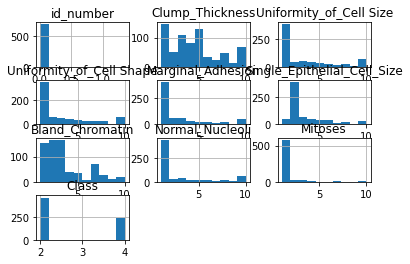

In [4]:
# There are many long tails and outliers with the feature distributions, so I will use sklearn's StandardScalar to soften them
print(data.hist())

In [5]:
# We also need to get the encoder to change the diagnosis "Class" from 2s and 4s to 0s and 1s
scalar = StandardScaler()
encoder = LabelEncoder()

In [6]:
'''
Note that there are 16 instances of '?' in this column.
According to the .names file, these are instances of missing data.
As a result, I am going to filter out these rows.
'''

data["Bare_Nuclei"].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [7]:
data = data[data.Bare_Nuclei != '?']

In [8]:
data["Bare_Nuclei"].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [9]:
X_raw = data.drop(columns=["id_number", "Class"])
y_raw = data["Class"]

In [10]:
X_nparray = X_raw.to_numpy()
X_nparray = X_nparray.astype("float64")

In [11]:
y_encoded = np.array(encoder.fit_transform(y_raw))
X_scaled = scalar.fit_transform(X_nparray)

In [12]:
y_encoded.shape

(683,)

In [13]:
X_scaled.shape

(683, 9)

In [14]:
# Get train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

In [15]:
# Make each of the splits into tensors

X_train_torch = Variable(torch.from_numpy(X_train))
y_train_torch = Variable(torch.from_numpy(y_train))

X_test_torch = Variable(torch.from_numpy(X_test))
y_test_torch = Variable(torch.from_numpy(y_test))

In [16]:
# Construct class for linear classifier neural network
class Linear_nn(torch.nn.Module):
    
    # Constructor class
    def __init__(self):
        super(Linear_nn, self).__init__()
        self.l1 = torch.nn.Linear(9, 6)
        self.l2 = torch.nn.Linear(6,3)
        self.l3 = torch.nn.Linear(3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
    
    # Feed forward class
    def forward(self, X):
        o1 = self.sigmoid(self.l1(X))
        o2 = self.sigmoid(self.l2(o1))
        
        predict = self.sigmoid(self.l3(o2))
        
        return predict

In [17]:
Linear_Model = Linear_nn()
 
def train_model(epochs, learning_rate):
    
    # Better results with sum as the loss function
    criterion = torch.nn.BCELoss(reduction='sum')
    
    # Using adam as optimizer
    optimizer = torch.optim.Adam(Linear_Model.parameters(), lr = learning_rate)
    
    print("Starting model with {} Epochs and Learning Rate: {}".format(epochs, learning_rate))

    for epoch in range(epochs):
        
        predict = Linear_Model(X_train_torch.float())
        loss = criterion(predict, y_train_torch.view(-1, 1).float())
        
        print("Epoch: {} | Loss: {} | Prediction: {}".format(epoch, loss, predict[0]))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

In [18]:
train_model(200, 0.01)

Starting model with 200 Epochs and Learning Rate: 0.01
Epoch: 0 | Loss: 415.36016845703125 | Prediction: tensor([0.4697], grad_fn=<SelectBackward0>)
Epoch: 1 | Loss: 412.0970458984375 | Prediction: tensor([0.4618], grad_fn=<SelectBackward0>)
Epoch: 2 | Loss: 409.0989685058594 | Prediction: tensor([0.4542], grad_fn=<SelectBackward0>)
Epoch: 3 | Loss: 406.3634338378906 | Prediction: tensor([0.4467], grad_fn=<SelectBackward0>)
Epoch: 4 | Loss: 403.8838806152344 | Prediction: tensor([0.4394], grad_fn=<SelectBackward0>)
Epoch: 5 | Loss: 401.650146484375 | Prediction: tensor([0.4325], grad_fn=<SelectBackward0>)
Epoch: 6 | Loss: 399.6484680175781 | Prediction: tensor([0.4258], grad_fn=<SelectBackward0>)
Epoch: 7 | Loss: 397.86236572265625 | Prediction: tensor([0.4194], grad_fn=<SelectBackward0>)
Epoch: 8 | Loss: 396.2730407714844 | Prediction: tensor([0.4133], grad_fn=<SelectBackward0>)
Epoch: 9 | Loss: 394.8607177734375 | Prediction: tensor([0.4075], grad_fn=<SelectBackward0>)
Epoch: 10 | Lo

Epoch: 125 | Loss: 132.69229125976562 | Prediction: tensor([0.1701], grad_fn=<SelectBackward0>)
Epoch: 126 | Loss: 131.6721954345703 | Prediction: tensor([0.1686], grad_fn=<SelectBackward0>)
Epoch: 127 | Loss: 130.6714630126953 | Prediction: tensor([0.1670], grad_fn=<SelectBackward0>)
Epoch: 128 | Loss: 129.6896209716797 | Prediction: tensor([0.1655], grad_fn=<SelectBackward0>)
Epoch: 129 | Loss: 128.72616577148438 | Prediction: tensor([0.1641], grad_fn=<SelectBackward0>)
Epoch: 130 | Loss: 127.78067016601562 | Prediction: tensor([0.1626], grad_fn=<SelectBackward0>)
Epoch: 131 | Loss: 126.8526840209961 | Prediction: tensor([0.1612], grad_fn=<SelectBackward0>)
Epoch: 132 | Loss: 125.9417953491211 | Prediction: tensor([0.1597], grad_fn=<SelectBackward0>)
Epoch: 133 | Loss: 125.04757690429688 | Prediction: tensor([0.1583], grad_fn=<SelectBackward0>)
Epoch: 134 | Loss: 124.16964721679688 | Prediction: tensor([0.1570], grad_fn=<SelectBackward0>)
Epoch: 135 | Loss: 123.30760192871094 | Predi

In [19]:
# Use the trained model to predict X_test as a tensor
y_predicted = Linear_Model.double().forward(X_test_torch) > 0.5

In [20]:
# Predicted truth and ground truth

PT = y_predicted.numpy()
GT = y_test_torch.numpy()

In [21]:
# Compare ground truth and prediction 
def get_results(GT, PT):
    # True positive
    TP = 0
    # False positive
    FP = 0
    # False negative
    FN = 0
    # True negative
    TN = 0
    
    for n in range(len(GT)):
        if GT[n] == 1 and PT[n] == True:
            TP += 1
        elif GT[n] == 0 and PT[n] == True:
            FP += 1
        elif GT[n] == 1 and PT[n] == False:
            FN += 1
        elif GT[n] == 0 and PT[n] == False:
            TN += 1
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = (2*precision*recall)/(precision+recall)
    
    print("--- Results -----------------")
    print("True Positives: {}".format(TP))
    print("False Positives: {}".format(FP))
    print("False Negatives: {}".format(FN))
    print("True Negatives: {}".format(TN))
    print("\nAccuracy: {}".format(accuracy))
    print("\nPrecision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 score: {}".format(F1))

In [22]:
get_results(PT, GT)

--- Results -----------------
True Positives: 29
False Positives: 1
False Negatives: 0
True Negatives: 39

Accuracy: 0.9855072463768116

Precision: 0.9666666666666667
Recall: 1.0
F1 score: 0.983050847457627
